In [2]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def simulation(par):
    P12, P23 = par # unpack parameters
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.add(m=1.) # Star
    sim.add(m=1e-4, P=1, theta='uniform')
    sim.add(m=1e-4, P=1/P12, theta='uniform')
    sim.add(m=1e-4, P=1/P12/P23, theta='uniform')
    sim.move_to_com()

    sim.dt = 0.05
    sim.init_megno()
    sim.exit_max_distance = 20.
    try:
        sim.integrate(1e4)
        megno = sim.megno()

        return megno
    except rebound.Escape:
        return 10. # At least one particle got ejected, returning large MEGNO.

In [4]:
def get_centered_grid(xlist, ylist, probs):
    # assumes uniformly spaced values in x and y (can have different lengths)
    dx = xlist[1]-xlist[0]
    dy = ylist[1]-ylist[0]

    xgrid = [x - dx/2 for x in xlist] + [xlist[-1]+dx/2]
    ygrid = [y - dy/2 for y in ylist] + [ylist[-1]+dy/2]

    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.array(probs).reshape(len(ylist),len(xlist))

    return X,Y,Z

In [5]:
from multiprocess import Pool

In [6]:
%%time
with Pool() as pool:
    # Ngrid = 2
    Ngrid = 80
    P12s = np.linspace(0.55, 0.76, Ngrid)
    P23s = np.linspace(0.55,0.76,Ngrid)
    parameters = []
    for P12 in P12s:
        for P23 in P23s:
            parameters.append((P12,P23))
    results = pool.map(simulation,parameters)

AttributeError: 'Simulation' object has no attribute 'megno'

NameError: name 'results' is not defined

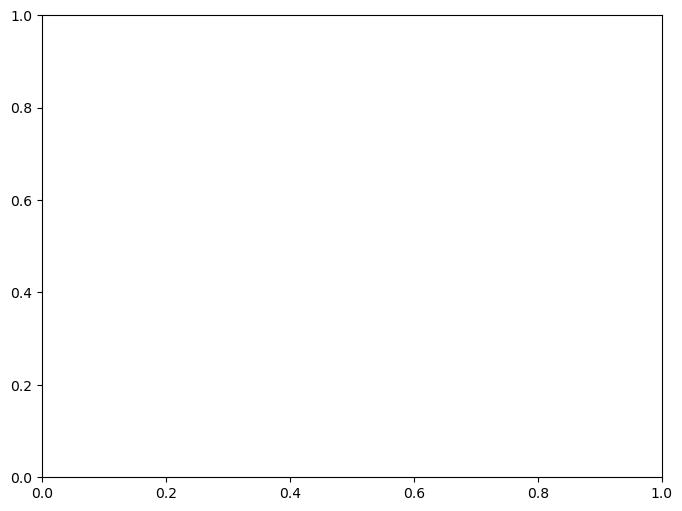

In [7]:
fig, ax = plt.subplots(figsize=(8,6))

X,Y,Z = get_centered_grid(P12s, P23s, results)
Zfilt = Z
Zfilt[Zfilt <2] = 2.01
im = ax.pcolormesh(X, Y, np.log10(Zfilt-2), vmin=-4, vmax=4, cmap='seismic')

cb = plt.colorbar(im, ax=ax)
cb.set_label("log(MEGNO-2) (red = chaotic)")
ax.set_xlabel("P1/P2")
ax.set_ylabel("P2/P3")